In [1]:
from PIL import Image, ImageEnhance
import numpy as np
import os
import torch.utils.data as data
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
import math
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# pix2pix

Класс для считывания данных и разделения оодной картинки на 2

In [3]:
class fascades(data.Dataset):
    def __init__(self, folder, resized_width, resized_height):
        super(fascades, self).__init__()
        self.folder = folder
        self.folder_files = os.listdir(self.folder)
        first_img = Image.open(os.path.join(self.folder, self.folder_files[0]))
        self.width, self.height = first_img.size
        self.resized_width = resized_width
        self.resized_height = resized_height


    def _load_and_devide_image(self, path):
        im = Image.open(path).convert('RGB')
        photo = im.crop((0, 0, self.width/2, self.height))
        pic = im.crop((self.width/2, 0, self.width, self.height))
        return photo, pic

    def __getitem__(self, idx):

        photo, pic = self._load_and_devide_image(os.path.join(self.folder, self.folder_files[idx]))

        photo_resized = photo.resize((self.resized_width, self.resized_height), Image.BICUBIC)
        pic_resized = pic.resize((self.resized_width, self.resized_height), Image.BICUBIC)

        photo_tensor = transforms.ToTensor()(photo_resized)
        pic_tensor = transforms.ToTensor()(pic_resized)
        return photo_tensor, pic_tensor

    def __len__(self):
        return len(self.folder_files)



Сетка

In [9]:
class block(nn.Module):
  def __init__(self, in_filters, out_filters, stride, has_skip=False, UseConvTranspose2d=False, bn=True):
      self.has_skip = has_skip
      super(block, self).__init__()
      if UseConvTranspose2d:
        block_in = [nn.Upsample(scale_factor=2, mode='nearest'), nn.Conv2d(in_filters, out_filters, 3, stride=stride, padding=1), nn.LeakyReLU(0.2, inplace=True)]
      else:
        block_in = [nn.Conv2d(in_filters, out_filters, 3, stride=stride, padding=1), nn.LeakyReLU(0.2, inplace=True)]
      if bn:
          block_in.append(nn.BatchNorm2d(out_filters, 0.8))
      self.in_block = nn.Sequential(*block_in)

  def forward(self, x):
    if self.has_skip:
      out = nn.ReLU(True)(x + self.in_block(x))
    else:
      out = self.in_block(x)
    return out

class Generator(nn.Module):
    def __init__(self, num_channels=3):
        super(Generator, self).__init__()

        self.conv_blocks = nn.Sequential(
                           nn.ReflectionPad2d(2),
                           nn.Conv2d(num_channels, 6, kernel_size=5, padding=0),
                           nn.BatchNorm2d(6, 0.8),
                           nn.ReLU(True),
                           block(6, 16, 2),
                           block(16, 32, 1, has_skip=False),
                           block(32, 64, 1, has_skip=False),
                           block(64, 128, 1, has_skip=False),
                           block(128, 256, 1, has_skip=False),
                           block(256, 256, 1, has_skip=True),
                           block(256, 256, 1, has_skip=True),
                           block(256, 256, 1, has_skip=True),
                           block(256, 256, 1, has_skip=True),
                           block(256, 256, 1, has_skip=True),
                           block(256, 256, 1, has_skip=True),
                           block(256, 256, 1, has_skip=True),
                           block(256, 128, 1, has_skip=False),
                           block(128, 64, 1, has_skip=False),
                           block(64, 32, 1, has_skip=False),
                           block(32, 16, 1, has_skip=False),
                           block(16, 6, 1, UseConvTranspose2d=True),
                           nn.ReflectionPad2d(2),
                           nn.Conv2d(6, num_channels, kernel_size=5, padding=0),
                           nn.ReLU()
                          )

    def forward(self, z):
        out = self.conv_blocks(z)
        return out



class Discriminator(nn.Module):
    def __init__(self, width, height, num_channels=3):
      super(Discriminator, self).__init__()
      self.init_size = width * height
      self.num_channels = num_channels

      first = width 
      for _ in range(4):
          first = math.ceil(first / 2.)

      second = height
      for _ in range(4):
          second = math.ceil(second / 2.)

      self.lin_size = 128 * first * second

      self.model = nn.Sequential(
          block(num_channels, 16, 2, bn=False),
          block(16, 32, 2),
          block(32, 64, 2),
          block(64, 128, 2),
      )
      self.adv_layer = nn.Linear(self.lin_size, 1)

    def forward(self, img):

        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity


Гиперпараметры модели

In [10]:
path_train = '/content/drive/MyDrive/facades/train'
path_test = '/content/drive/MyDrive/facades/test'
batch_size = 10
gen_lr = 0.0001
desc_lr = 0.0001
L1_weight = 8
num_epochs = 10

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
ds = fascades(path_train, 200, 200)
train_dl = data.DataLoader(dataset=ds, batch_size=batch_size, shuffle=True)

In [12]:
gen = Generator().to(device)
desc = Discriminator(ds.resized_width, ds.resized_height).to(device)

GAN_loss = nn.MSELoss().to(device)
L1_loss = nn.L1Loss().to(device)

optimizer_gen = optim.Adam(gen.parameters(),lr=gen_lr, betas=(0.5, 0.999))
optimizer_desc = optim.Adam(desc.parameters(),lr=desc_lr, betas=(0.5, 0.999))


In [13]:
for epoch in tqdm(range(num_epochs)):
  for iteration, batch in enumerate(train_dl, 1):
      optimizer_desc.zero_grad()

      true_photo, true_pic = batch[0].to(device), batch[1].to(device)
      # Геерируеем ненастоящие фото
      fake_photo = gen(true_pic)
      # Считаеем предсказания дескриминатора на ненастоящих фото
      fake_cat_in = torch.cat((true_pic, fake_photo), 0).detach()
      fake_cat = desc.forward(fake_cat_in)
      loss_desc_fake = GAN_loss(fake_cat, torch.tensor(0.0).expand_as(fake_cat).to(device))
      # Считаеем предсказания дескриминатора на настоящих фото
      true_cat_in = torch.cat((true_pic, true_photo), 0)
      true_cat = desc.forward(true_cat_in)
      loss_desc_real = GAN_loss(true_cat, torch.tensor(1.0).expand_as(true_cat).to(device))
      # Объединяеем лоссы
      loss_desc = loss_desc_fake + loss_desc_real
      # Делаем шаг по дескриминатору
      loss_desc.backward()
      optimizer_desc.step()
      
      # Получаем новые предсказания дескриминатора
      optimizer_gen.zero_grad()
      fake_cat_in = torch.cat((true_pic, fake_photo), 0)
      fake_cat = desc.forward(fake_cat_in)
      loss_gen_gan = GAN_loss(fake_cat, torch.tensor(1.0).expand_as(fake_cat).to(device))

      # Деелаем шаг генератора
      loss_gen_l1 = L1_loss(true_photo, fake_photo)
      loss_gen = loss_gen_gan + loss_gen_l1 * L1_weight
      loss_gen.backward()
      optimizer_gen.step()

  print(f"Epoch{epoch}: Loss_descriminator: {loss_desc.item()} Loss_generator: {loss_gen.item()}")

 10%|█         | 1/10 [02:53<26:05, 173.91s/it]

Epoch0: Loss_descriminator: 0.309561163187027 Loss_generator: 2.855377197265625


 20%|██        | 2/10 [03:05<16:42, 125.29s/it]

Epoch1: Loss_descriminator: 0.16037005186080933 Loss_generator: 2.8375675678253174


 30%|███       | 3/10 [03:17<10:38, 91.26s/it] 

Epoch2: Loss_descriminator: 0.3061854839324951 Loss_generator: 2.2382514476776123


 40%|████      | 4/10 [03:29<06:44, 67.43s/it]

Epoch3: Loss_descriminator: 0.1333727240562439 Loss_generator: 2.4663538932800293


 50%|█████     | 5/10 [03:41<04:13, 50.75s/it]

Epoch4: Loss_descriminator: 0.4612582325935364 Loss_generator: 2.2186760902404785


 60%|██████    | 6/10 [03:53<02:36, 39.08s/it]

Epoch5: Loss_descriminator: 0.307621568441391 Loss_generator: 2.802564859390259


 70%|███████   | 7/10 [04:04<01:32, 30.90s/it]

Epoch6: Loss_descriminator: 0.28882575035095215 Loss_generator: 2.0923140048980713


 80%|████████  | 8/10 [04:16<00:50, 25.18s/it]

Epoch7: Loss_descriminator: 0.24137605726718903 Loss_generator: 2.2185170650482178


 90%|█████████ | 9/10 [04:28<00:21, 21.18s/it]

Epoch8: Loss_descriminator: 0.2949664294719696 Loss_generator: 2.0377438068389893


100%|██████████| 10/10 [04:40<00:00, 28.04s/it]

Epoch9: Loss_descriminator: 0.32449841499328613 Loss_generator: 2.0028979778289795


Прогоним тестовую выборку и посмотрим на результат. Сначала будем выводить картинку, потом наше предсказание, потом настоящее фото.

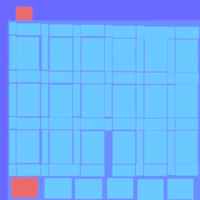

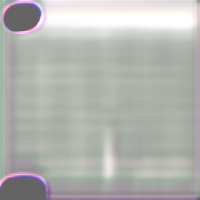

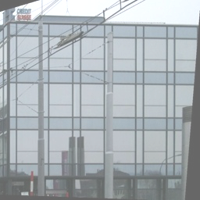

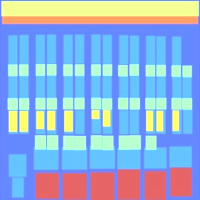

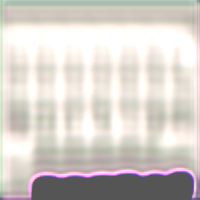

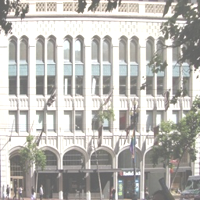

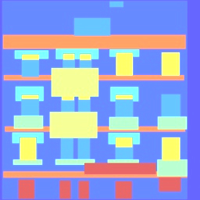

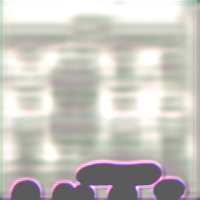

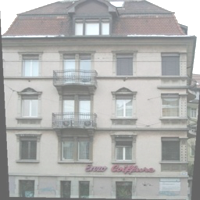

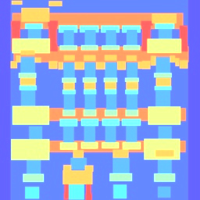

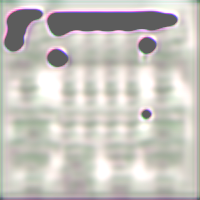

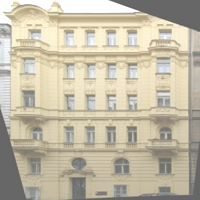

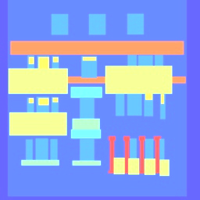

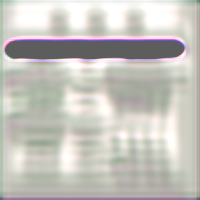

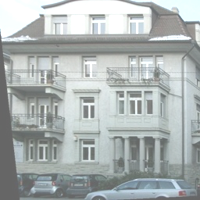

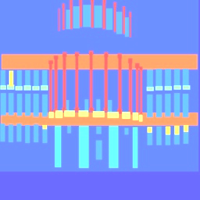

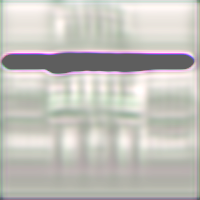

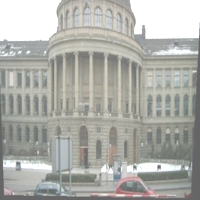

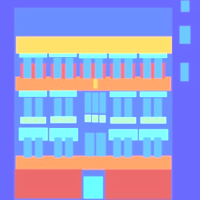

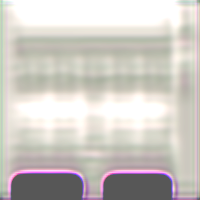

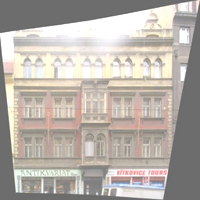

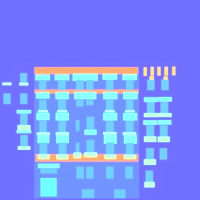

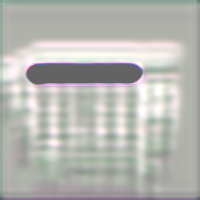

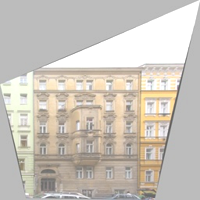

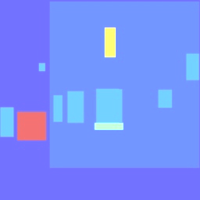

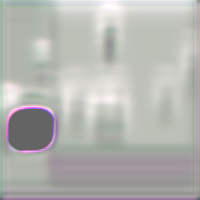

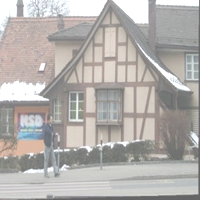

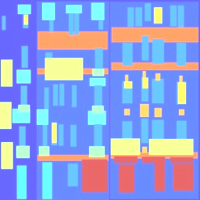

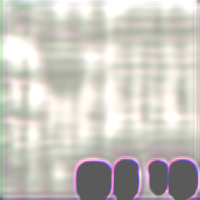

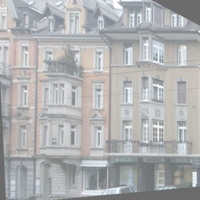

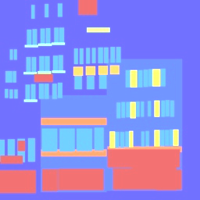

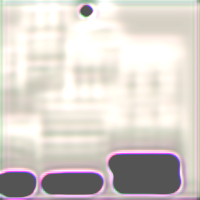

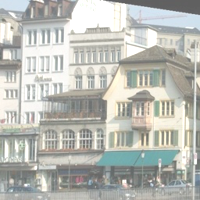

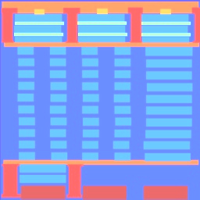

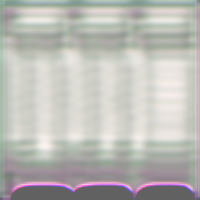

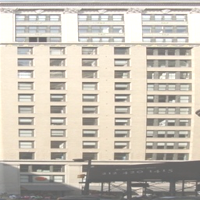

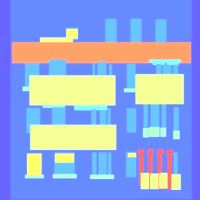

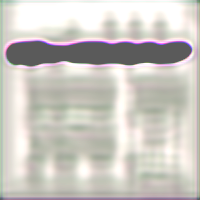

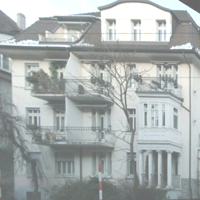

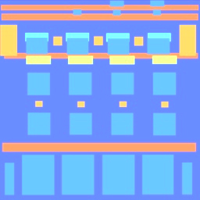

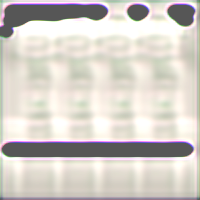

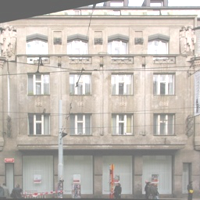

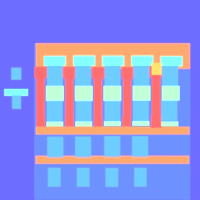

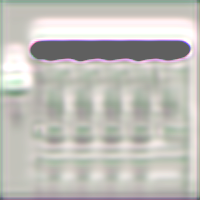

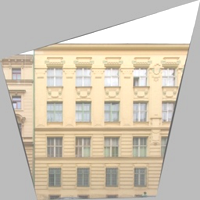

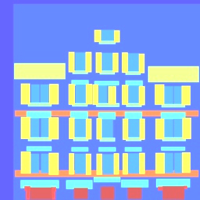

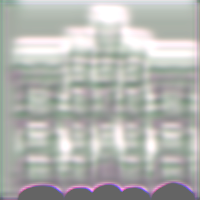

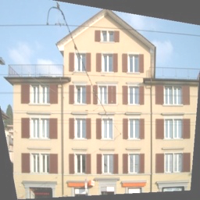

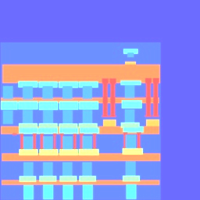

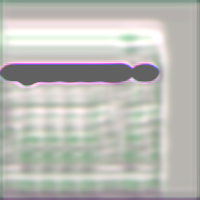

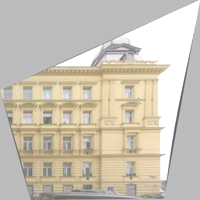

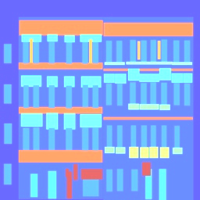

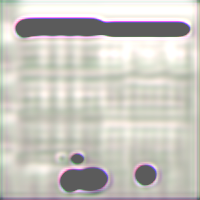

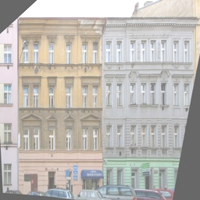

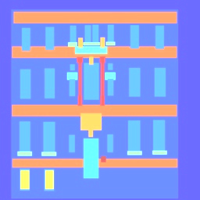

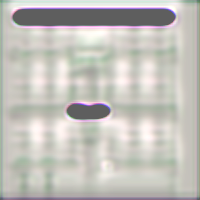

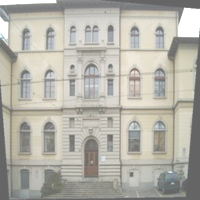

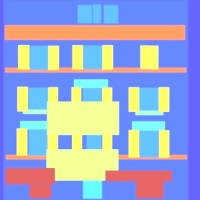

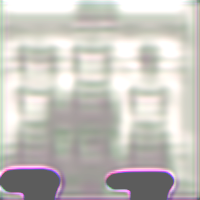

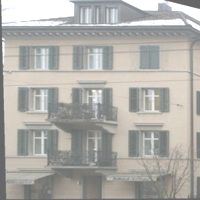

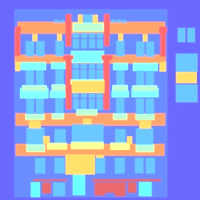

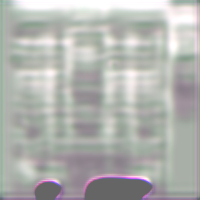

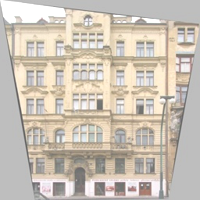

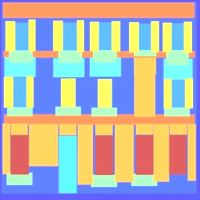

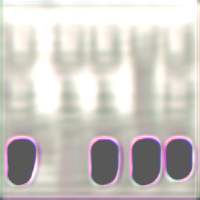

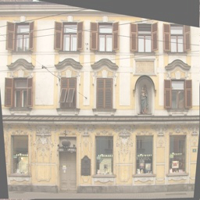

KeyboardInterrupt: ignored

In [14]:
test_ds = fascades(path_test, 200, 200)

def image_from_tensor(image_tensor):
    image_numpy = image_tensor.float().numpy()
    image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1)/ 2.0 * 255
    image_numpy = image_numpy.clip(0, 255)
    image_numpy = image_numpy.astype(np.uint8)
    image_pil = Image.fromarray(image_numpy)
    contrast = ImageEnhance.Contrast(image_pil)
    return contrast.enhance(1.5)

for photo, pic in test_ds:
    
    input = pic.unsqueeze(0).to(device)
    fake_photo_g = gen(input)
    fake_photo = fake_photo_g.detach().squeeze(0).cpu()

    pic_img = image_from_tensor(pic)
    true_photo_img = image_from_tensor(photo)
    fake_photo_img = image_from_tensor(fake_photo)


    display(pic_img, fake_photo_img, true_photo_img)
    print('\n')

Мы явно чему-то учимся, но как-то получилось не фонтан. Скорее всего проблема в генераторе, но в чем конкретно: в идеологи, архитекетуре или просто количествее эпох понять не успеваю(